In [15]:
# Simulate exoplanet yield from TESS

The purpose of this code is to simulate the exoplanet yield from the TESS Mission. We do this by taking the various fields that TESS observes and, using a galaxy model, put planets orbiting the stars and see whether we can detect that planet.

In [16]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import astroquery
import matplotlib.pyplot as plt
import glob

%matplotlib inline

msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.


lets read our galaxt model files

In [17]:
import matplotlib
matplotlib.style.use('ggplot')

names = ['Dist','Mv','CL','Typ','LTef','logg','Age',
         'Mass','BV','UB','VI','VK','V','FeH',
         'l','b','Av','Mbol']

galmodfiles = glob.glob('../data/besmod*.csv')

thisGalmodidx = 0

galmodarea = np.genfromtxt('bess_reas.txt',usecols=2)[thisGalmodidx]

intial_q = pd.read_csv(galmodfiles[thisGalmodidx], skiprows=2, names=names)


In [18]:
intial_q['isMdwarf'] = pd.Series((intial_q.CL == 5) & (intial_q.Typ >= 7.), name='isMdwarf' )
intial_q['I'] = pd.Series(-1. * (intial_q.VI - intial_q.V), name='I')
intial_q['Teff'] = pd.Series(10**intial_q.LTef , name='Teff')

g = 10**intial_q.logg * 0.01
intial_q['Radius'] = pd.Series(np.sqrt(G*intial_q.Mass*msun / g) / rsun, name='Radius')

we previously got the besancon models, they are in the directory ../data/
We also saved the areas for each field in bess_reas.txt

We are doing this in a monte carlo fashion. Our outer loop is each field. The row closest to the equator is easiest because there is no overlap.
We saved a few functions in occSimFuncs.py

In [104]:
#from occSimFuncs import (Fressin13_select, Dressing15_select, per2ars, 
#                         get_duration, TESS_noise_1h, nearly_equal, get_transit_depth, get_rprs)
import occSimFuncs as occFunc


consts =  {'obslen': 27, #days
            'sigma_threshold': 10.,
           'simsize': 8, #size of the galmod field in sq deg
            'full_fov': True, # if true do whole 24x24deg ccd
          }

#make the catalog equal to the full fov area
if consts['full_fov'] & (consts['simsize'] < galmodarea):
    multiple = galmodarea / consts['simsize']
    numstars = int(intial_q.shape[0] * multiple)
    rows = np.random.choice(intial_q.index.values, size=numstars)
    newq = intial_q.ix[rows]
    
    q = newq.set_index(np.arange(newq.shape[0]))
    
elif (simsize > galmodarea):
    raise('Galmod area is too small!')

else:
    q = intial_q



#some planet parameters we will need later
q['cosi'] = pd.Series(np.random.random(size=q.shape[0]),name='cosi')
# this cosi will be the same for every planet in the system

q['noise_level'] = occFunc.TESS_noise_1h(q.I)



In [105]:
from numpy.random import poisson, beta, uniform
np_fgk = poisson(lam=0.689,size=q.shape[0])
np_m = poisson(lam=2.5,size=q.shape[0])
q['Nplanets'] = pd.Series(np.where(q.isMdwarf, np_m,np_fgk), name='Nplanets')

draw a bunch of planest and accociate them with each star

In [106]:
# this cell has been replaced the vector version below

# %%timeit 

# q['planetRadius'] = pd.Series()
# q['planetPeriod'] = pd.Series()
# q['starID'] = pd.Series()

# newDF = pd.DataFrame(columns=q.columns)
# starID = 0
# for thisRow in np.arange(q.shape[0])[0:500]:
#     if q.loc[thisRow,'isMdwarf']:
#         radper = occFunc.Dressing15_select(q.loc[thisRow, 'Nplanets'])
#         if q.loc[thisRow,'Nplanets'] == 0:
#             continue
#         elif q.loc[thisRow,'Nplanets'] == 1:
#             q.loc[thisRow,'planetRadius'] = radper[0]
#             q.loc[thisRow,'planetPeriod'] = radper[1]
#             q.loc[thisRow,'starID'] = starID
#             newDF = newDF.append(q.loc[thisRow])
#             starID +=1
#         elif q.loc[thisRow,'Nplanets'] >= 2:
#             q.loc[thisRow,'starID'] = starID
#             for p in np.arange(q.loc[thisRow,'Nplanets']):
#                 q.loc[thisRow,'planetRadius'] = radper[0][p]
#                 q.loc[thisRow,'planetPeriod'] = radper[1][p]
#                 newDF = newDF.append(q.loc[thisRow])
#             starID +=1
        
#     elif not q.loc[thisRow,'isMdwarf']:
#         radper = occFunc.Fressin13_select(q.loc[thisRow, 'Nplanets'])
#         if q.loc[thisRow,'Nplanets'] == 0:
#             continue
#         elif q.loc[thisRow,'Nplanets'] == 1:
#             q.loc[thisRow,'planetRadius'] = radper[0]
#             q.loc[thisRow,'planetPeriod'] = radper[1]
#             q.loc[thisRow,'starID'] = starID
#             newDF = newDF.append(q.loc[thisRow])
#             starID +=1
#         elif q.loc[thisRow,'Nplanets'] >= 2:
#             q.loc[thisRow,'starID'] = starID
#             for p in np.arange(q.loc[thisRow,'Nplanets']):
#                 q.loc[thisRow,'planetRadius'] = radper[0][p]
#                 q.loc[thisRow,'planetPeriod'] = radper[1][p]
#                 newDF = newDF.append(q.loc[thisRow])    
#             starID += 1

# newDF.set_index(np.arange(newDF.shape[0]), inplace=True)

In [107]:
# lets refector the above code to make it array operations
totalRows = q['Nplanets'].sum()

q['planetRadius'] = pd.Series()
q['planetPeriod'] = pd.Series()
q['starID'] = pd.Series()

radper_dressing = occFunc.Dressing15_select(totalRows)
radper_fressin = occFunc.Fressin13_select(totalRows)

#we need an array of indices
totalRows = q['Nplanets'].sum()
rowIdx =np.zeros(totalRows)
rownum = 0
rowIdx = np.repeat(np.arange(q.shape[0]),np.array(q.Nplanets.values))

newDF = q.iloc[rowIdx]
newDF.starID = rowIdx

# newDF = pd.DataFrame(columns=q.columns, index=np.arange(totalRows))
# starID = 0
# rowIdx = 0
# for thisRow in np.arange(q.shape[0]):
#     if q.loc[thisRow,'Nplanets'] == 0:
#         continue
#     else:
#         q.loc[thisRow,'starID'] = starID
#         nplanets = q.loc[thisRow,'Nplanets']
#         for pnum in range(nplanets):
#             newDF.iloc[rowIdx+nplanets] = q.iloc[thisRow]
        
#         rowId += nplanets
#         starID += 1
        
newDF.planetRadius = np.where(newDF.isMdwarf,radper_dressing[0],radper_fressin[0])
newDF.planetPeriod = np.where(newDF.isMdwarf,radper_dressing[1],radper_fressin[1])
newDF.set_index(np.arange(newDF.shape[0]), inplace=True)

In [114]:
newDF['Ntransits'] = np.floor(consts['obslen'] / newDF.planetPeriod)
newDF['ars'] = occFunc.per2ars(newDF.planetPeriod,newDF.Mass,newDF.Radius)
newDF['ecc'] = pd.Series(beta(1.03,13.6,size=newDF.shape[0]),name='ecc', ) # ecc dist from Van Eylen 2015
newDF['omega'] = pd.Series(uniform(-np.pi,np.pi,size=newDF.shape[0]),name='omega')
newDF['rprs'] = occFunc.get_rprs(newDF.planetRadius,newDF.Radius)
newDF['impact'] = newDF.cosi * newDF.ars * ((1-newDF.ecc**2)/1+newDF.ecc*np.sin(newDF.omega)) # cite Winn
newDF['duration'] = occFunc.get_duration(newDF.planetPeriod,newDF.ars,cosi=newDF.cosi, b=newDF.impact,
                                rprs=newDF.rprs) # cite Winn
newDF['duration_correction'] = np.sqrt(newDF.duration * 24.) # correction for CDPP because transit dur != 1 hour
newDF['transit_depth']  = occFunc.get_transit_depth(newDF.planetRadius,newDF.Radius)

/Users/tom/.virtualenvs/p1/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/tom/.virtualenvs/p1/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/tom/.virtualenvs/p1/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

now lets see if those planets are detected

In [115]:
newDF['needed_for_detection'] = (newDF.transit_depth * newDF.duration_correction *
            np.sqrt(newDF.Ntransits)) / consts['sigma_threshold']
newDF['has_transits']  = (newDF.ars > 1.0) & (newDF.impact < 1.0)

/Users/tom/.virtualenvs/p1/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/tom/.virtualenvs/p1/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [116]:
newDF['detected'] = (newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits

/Users/tom/.virtualenvs/p1/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [117]:
total_planets = newDF.detected.sum()
print('total planets = {}'.format(np.sum(total_planets)))

total planets = 52


(0, 22)

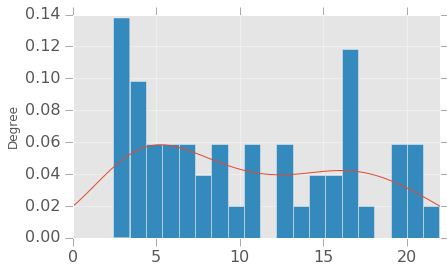

In [118]:
query_name = 'detected == True and planetRadius < 30.'
mask = (newDF.detected == True) & (newDF.planetRadius < 30)
#newDF.query(query_name).plot(x='planetPeriod',y='planetRadius',kind='hist',)
newDF.planetRadius[mask].plot(kind='kde')
newDF.planetRadius[mask].plot(kind='hist',normed=True,bins=20)
plt.xlim([0,22])

In [111]:
newDF

,Dist,Mv,CL,Typ,LTef,logg,Age,Mass,BV,UB,...,starID,Ntransits,ars,ecc,omega,rprs,impact,duration,duration_correction,transit_depth
0,0.750,4.6,5,4.80,3.787,4.38,8,0.86,0.503,-0.121,...,0,1,28.244662,0.016583,-1.275286,0.008169,16.717508,NaN,NaN,66.730104
1,0.350,6.3,5,6.30,3.682,4.55,3,0.81,1.046,0.905,...,3,0,62.273969,0.125421,-1.226291,0.041687,38.386748,NaN,NaN,1737.831703
2,0.350,6.3,5,6.30,3.682,4.55,3,0.81,1.046,0.905,...,3,0,52.912441,0.112921,-1.095418,0.036001,33.392952,NaN,NaN,1296.073472
3,0.171,8.9,5,7.00,3.590,4.72,2,0.60,1.409,1.281,...,5,2,34.582024,0.070176,1.275336,0.018574,8.279666,NaN,NaN,344.996937
4,0.171,8.9,5,7.00,3.590,4.72,2,0.60,1.409,1.281,...,5,1,49.082180,0.051336,-2.202730,0.011692,10.575654,NaN,NaN,136.703120
5,0.171,8.9,5,7.00,3.590,4.72,2,0.60,1.409,1.281,...,5,4,21.185604,0.007102,-2.772357,0.032011,4.762730,NaN,NaN,1024.735881
6,0.171,8.9,5,7.00,3.590,4.72,2,0.60,1.409,1.281,...,5,3,27.288639,0.055806,-0.517847,0.040616,5.961760,NaN,NaN,1649.662026
7,0.430,5.7,5,6.00,3.712,4.52,7,0.86,0.836,0.389,...,8,3,19.543418,0.336816,-1.883438,0.016060,5.979083,NaN,NaN,257.936023
8,0.430,5.7,5,6.00,3.712,4.52,7,0.86,0.836,0.389,...,8,1,27.931045,0.036632,1.448839,0.016007,15.624343,NaN,NaN,256.211621
9,0.830,3.6,5,5.00,3.770,4.04,7,1.12,0.622,0.085,...,9,3,9.631477,0.007880,1.253025,0.007468,1.193001,-0.096339,NaN,55.769111


In [86]:
totalRows = q['Nplanets'].sum()
rowIdx =np.zeros(totalRows)
rownum = 0
rowIdx = np.repeat(np.arange(q.shape[0]),np.array(q.Nplanets.values))

In [89]:
rowIdx[0:10]

array([ 0,  0,  1,  5,  6,  7, 10, 12, 12, 14])

In [88]:
q.Nplanets

0        2
1        1
2        0
3        0
4        0
5        1
6        1
7        1
8        0
9        0
10       1
11       0
12       2
13       0
14       2
15       0
16       1
17       3
18       2
19       0
20       0
21       0
22       1
23       0
24       1
25       1
26       1
27       1
28       0
29       2
        ..
77802    0
77803    1
77804    0
77805    1
77806    1
77807    1
77808    1
77809    0
77810    1
77811    2
77812    1
77813    0
77814    1
77815    1
77816    1
77817    2
77818    2
77819    1
77820    0
77821    1
77822    0
77823    1
77824    0
77825    0
77826    1
77827    0
77828    1
77829    1
77830    1
77831    0
Name: Nplanets, dtype: int64

In [70]:
pd.concat([q.iloc[thisRow:thisRow+1]]*5)

,Dist,Mv,CL,Typ,LTef,logg,Age,Mass,BV,UB,...,isMdwarf,I,Teff,Radius,cosi,noise_level,Nplanets,planetRadius,planetPeriod,starID
0,0.69,3.6,3,5.6,3.69,3.63,7,1.09,0.979,0.649,...,False,11.865,4897.788194,2.648087,0.532492,505.898622,2,NaN,NaN,0
0,0.69,3.6,3,5.6,3.69,3.63,7,1.09,0.979,0.649,...,False,11.865,4897.788194,2.648087,0.532492,505.898622,2,NaN,NaN,0
0,0.69,3.6,3,5.6,3.69,3.63,7,1.09,0.979,0.649,...,False,11.865,4897.788194,2.648087,0.532492,505.898622,2,NaN,NaN,0
0,0.69,3.6,3,5.6,3.69,3.63,7,1.09,0.979,0.649,...,False,11.865,4897.788194,2.648087,0.532492,505.898622,2,NaN,NaN,0
0,0.69,3.6,3,5.6,3.69,3.63,7,1.09,0.979,0.649,...,False,11.865,4897.788194,2.648087,0.532492,505.898622,2,NaN,NaN,0


array([ 0.81202969,  1.07044505,  1.05682186,  1.73476427])